# Notebook for training computer vision models for BugID

In [1]:
#Load libraries and constants
import timm
from fastai.vision.all import *
import pandas as pd
from torchvision import transforms
import torch
import cv2
import numpy as np

image_dir = Path("image_preproc")
model_dir = Path("models")
data_dir = Path("data")

img_size = 300

In [2]:
#Calculate weigths per class because of imbalanced data distribution
targets = [parent_label(i) for i in get_image_files(image_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]
n_classes = len(count)

In [3]:
#Define dataloaders
bs = 32

block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=1, size=img_size, min_scale=0.3, flip_vert=True),
                  get_y = parent_label)
    
loaders = block.weighted_dataloaders(image_dir, wgts=wgts, bs=bs)

In [5]:
#Write model vocabolary to file
vocab = loaders.vocab

with open(data_dir/"vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

In [4]:
#Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) # if p.requires_grad

In [5]:
#List learners to benchmark
learners = ["resnet18", "resnet34", "resnet50", 
            "mobilenetv2_050", "mobilenetv2_100", "mobilenetv2_140",
            "convnext_nano", "convnext_tiny"]

In [8]:
#Iterate over all learners and obtain validation statistics
results = []

for name in learners:
    
    #Define learner
    learn = vision_learner(loaders, 
                           name,
                           pretrained=True,
                           normalize=True,
                           loss_func=LabelSmoothingCrossEntropy(),
                           metrics=[accuracy, top_k_accuracy],
                           cbs=SaveModelCallback(fname=name)).to_fp16()

    #Fine-tune learner
    learn.fine_tune(epochs=15, freeze_epochs=3)

    #Count parameters
    n_params = count_parameters(learn)

    #Get validation set metrics
    preds, targets = learn.get_preds()

    val_acc = accuracy(preds, targets)
    val_top5 = top_k_accuracy(preds, targets)
    
    results.append({"model": name, "val_acc": val_acc.item(), "val_top5": val_top5.item(), "n_params": n_params})

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


KeyboardInterrupt: 

In [18]:
#Export benchmark results
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir/"benchmark.csv", index=False)

In [4]:
#Load learner for inspection and export
model_name = "resnet18"

learn = vision_learner(loaders, 
                       model_name,
                       pretrained=True,
                       normalize=True).load(model_name)


/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


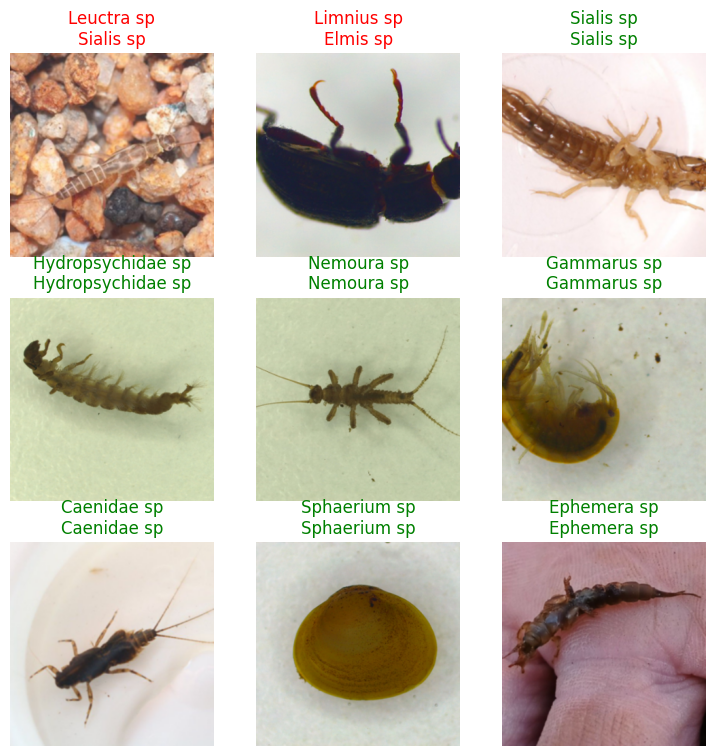

In [5]:
#Show example predictions
learn.show_results()

In [8]:
#Create confusion matrix
interpreter = ClassificationInterpretation.from_learner(learn)

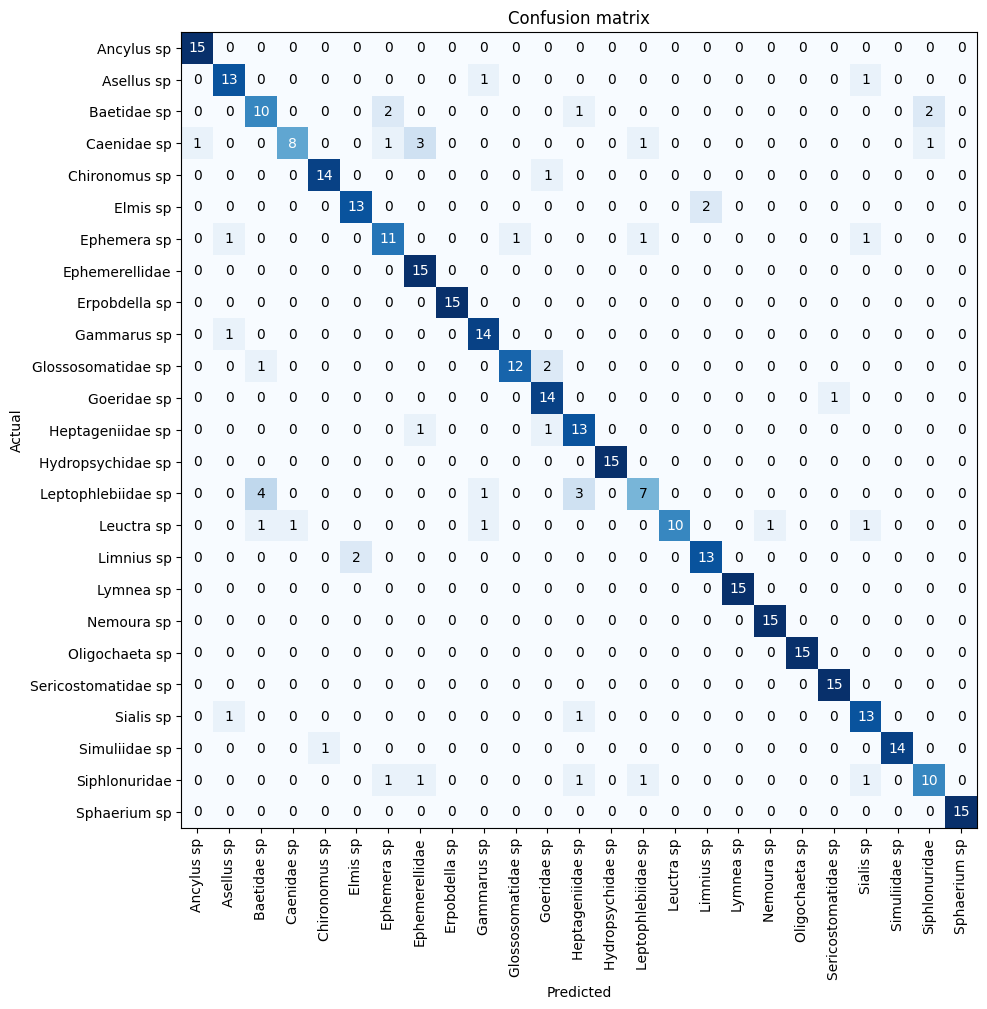

In [9]:
interpreter.plot_confusion_matrix(figsize=(10,10))

In [50]:
#Define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#Define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#Assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)
final_model.eval()

Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
                (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Linear(in_features=96, out_features=384, bias=True)
                  (act): GELU(approximate='none')
                  (drop1): Dropout(p=0.0, inplace=False)
                  (fc2): Linear(in_features=384, out_features=96, bias=True)
                  (drop2): Dropout(p=0.0, inpl

In [51]:
#Generate model sample input
dummy_input = torch.randn(1, 3, img_size, img_size, requires_grad=True)

onnx_model_path = model_dir/f"{model_name}.onnx"

In [52]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#Model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [10]:
#Test fastai and ONNX model predictions
image_sample = "image_preproc/valid/Asellus sp/CPH-Asellus sp.-15.png"

In [11]:
#Get fastai predictions for sample image
spec, idx, probs = learn.predict(image_sample)

In [12]:
#Load ONNX model using opencv
model = cv2.dnn.readNetFromONNX(f"models/{model_name}.onnx")

In [13]:
#Preprocess sample image using opencv (similar to GUI)
model_input = cv2.dnn.blobFromImage(
                image = cv2.imread(image_sample),
                scalefactor = 1/255,
                size = (img_size, img_size),
                swapRB=True,
                crop=True)

In [14]:
#Get ONNX model predictions
model.setInput(model_input)
probs_onnx = model.forward().squeeze()

In [15]:
probs_onnx, probs.numpy()

(array([2.60631146e-04, 9.46781814e-01, 1.14743086e-03, 6.17995451e-04,
        2.96138198e-04, 4.33298806e-03, 8.77869956e-04, 2.60804454e-03,
        1.38991175e-03, 1.31779793e-03, 1.94698761e-04, 9.14574775e-04,
        3.00317397e-03, 3.28019145e-03, 1.32045115e-03, 2.94361787e-04,
        1.71702879e-03, 2.38281651e-03, 5.15560759e-03, 3.19016632e-03,
        2.57543498e-03, 1.43922549e-02, 1.11520916e-04, 8.32283229e-04,
        1.00487203e-03], dtype=float32),
 array([2.7396166e-04, 9.4236773e-01, 1.5724044e-03, 7.6030206e-04,
        2.5420327e-04, 1.7792325e-03, 7.1741513e-04, 4.2780987e-03,
        1.0485376e-03, 1.6571085e-03, 1.7973578e-04, 1.0164917e-03,
        2.0670770e-03, 2.4683217e-03, 8.9907495e-04, 2.6985758e-04,
        8.0036878e-04, 1.0924179e-03, 4.2353254e-03, 3.2437122e-03,
        1.1728061e-03, 2.6622111e-02, 1.1047949e-04, 4.3824143e-04,
        6.7501655e-04], dtype=float32))

In [6]:
#https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

#Shap image explanations

import shap
import torchvision

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minim

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = learn.model

model.to(device)
model.eval()

Sequential(
  (0): TimmBody(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64

In [8]:
class_names = learn.dls.vocab

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x):
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x):
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    #torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

def predict(img):
    #img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [10]:
X, y = next(iter(learn.dls.train))

In [11]:
X[1:3], y[1:3]

(TensorImage([[[[-2.5697e-01, -2.7023e-01, -2.8186e-01,  ..., -2.1179e+00,
                 -2.1179e+00, -2.1179e+00],
                [-2.6870e-01, -2.6982e-01, -2.7179e-01,  ..., -2.1179e+00,
                 -2.1179e+00, -2.1179e+00],
                [-2.6983e-01, -2.6994e-01, -2.7198e-01,  ..., -2.1179e+00,
                 -2.1179e+00, -2.1179e+00],
                ...,
                [-3.7305e-01, -3.5222e-01, -3.3640e-01,  ..., -2.1179e+00,
                 -2.1179e+00, -2.1179e+00],
                [-3.7561e-01, -3.6352e-01, -3.5526e-01,  ..., -2.1179e+00,
                 -2.1179e+00, -2.1179e+00],
                [-3.7829e-01, -3.7829e-01, -3.7829e-01,  ..., -2.1179e+00,
                 -2.1179e+00, -2.1179e+00]],
 
               [[ 1.4906e-02,  1.3330e-03, -1.0582e-02,  ..., -2.0357e+00,
                 -2.0357e+00, -2.0357e+00],
                [ 2.8992e-03,  1.7480e-03, -2.6929e-04,  ..., -2.0357e+00,
                 -2.0357e+00, -2.0357e+00],
                [ 1.7373

In [12]:
y_hat = predict(X[1:3])

In [13]:
classes = torch.argmax(y_hat, axis=1).cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [10 17]: ['Glossosomatidae sp' 'Lymnea sp']


In [14]:
class_names

['Ancylus sp', 'Asellus sp', 'Baetidae sp', 'Caenidae sp', 'Chironomus sp', 'Elmis sp', 'Ephemera sp', 'Ephemerellidae', 'Erpobdella sp', 'Gammarus sp', 'Glossosomatidae sp', 'Goeridae sp', 'Heptageniidae sp', 'Hydropsychidae sp', 'Leptophlebiidae sp', 'Leuctra sp', 'Limnius sp', 'Lymnea sp', 'Nemoura sp', 'Oligochaeta sp', 'Sericostomatidae sp', 'Sialis sp', 'Simuliidae sp', 'Siphlonuridae', 'Sphaerium sp']

In [15]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[1:3][0].shape)

#wait for new release??

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations